In [1]:
from train_sam_ultrasound_segmentation import (
    SamWrapper,
    ImagesAndUltrasoundMasksDataset,
)
from segment_anything.predictor import SamPredictor
from segment_anything.build_sam import sam_model_registry
import cv2
import matplotlib.pyplot as plt
import argparse
import torch
import os
from tqdm import tqdm
from glob import glob
import sys
import re
import shutil
import argparse 

args = argparse.Namespace()

# SET THESE ACCORDING TO YOUR FILE SYSTEM
args.sam_type = "vit_b"
args.sam_weights = "sam_vit_b_01ec64.pth"
args.train_checkpoint = '/home/paulw/Challenge_Code/checkpoints/ultrasound_detect/2024-04-20_14:37/vit_b_best.pt'

DEVICE = 'cuda'

sam_model = sam_model_registry[args.sam_type](args.sam_weights)
model = SamWrapper(sam_model)

print(f"Loading checkpoint: {args.train_checkpoint}")
model.load_state_dict(torch.load(args.train_checkpoint, map_location=DEVICE))
model.eval().to(DEVICE)
predictor = SamPredictor(model.model)

Loading checkpoint: /home/paulw/Challenge_Code/checkpoints/ultrasound_detect/2024-04-20_14:37/vit_b_best.pt


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




In [57]:
def get_mask_prediction(image, predictor):
    with torch.no_grad():
        with torch.cuda.amp.autocast_mode.autocast():
            predictor.set_image(image)
            masks, _, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=None,
                multimask_output=False,
            )
            return masks[0].astype("uint8")

def show(image, mask):
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5 * mask)
    plt.axis("off")

In [68]:
# SET THESE TO POINT TO THE FOLDERS WITH TEST VIDEOS

video_folders = [f'Test_{str(i + 1).zfill(2)}' for i in range(20)]
print(video_folders)

['Test_01', 'Test_02', 'Test_03', 'Test_04', 'Test_05', 'Test_06', 'Test_07', 'Test_08', 'Test_09', 'Test_10', 'Test_11', 'Test_12', 'Test_13', 'Test_14', 'Test_15', 'Test_16', 'Test_17', 'Test_18', 'Test_19', 'Test_20']


In [60]:
import numpy as np
from tqdm import tqdm

# generate the test predictions

for video_folder in video_folders: 

    output_path = f'{video_folder}_segmentations.npy'
    print(f'Processing folder {video_folder}')

    frames = sorted(list(glob(f"{video_folder}/*.jpg")))
    n_frames = len(frames)

    # get height and width
    image = cv2.imread(frames[0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    H, W, C = image.shape 

    output_array = np.zeros(
        (n_frames, H, W), dtype='uint8'
    )

    for i, frame in enumerate(tqdm(frames)): 
        image = cv2.imread(frame)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = get_mask_prediction(image, predictor)
        output_array[i][:] = mask


    np.save(output_path, output_array)


Processing folder Test_01


100%|██████████| 1232/1232 [01:48<00:00, 11.38it/s]


Processing folder Test_02


100%|██████████| 1377/1377 [02:02<00:00, 11.28it/s]


Processing folder Test_03


100%|██████████| 813/813 [01:12<00:00, 11.17it/s]


Processing folder Test_04


100%|██████████| 482/482 [00:43<00:00, 11.10it/s]


Processing folder Test_05


100%|██████████| 488/488 [00:44<00:00, 11.06it/s]


Processing folder Test_06


100%|██████████| 512/512 [00:46<00:00, 11.04it/s]


Processing folder Test_07


100%|██████████| 707/707 [01:04<00:00, 11.01it/s]


Processing folder Test_08


100%|██████████| 1056/1056 [01:35<00:00, 11.09it/s]


Processing folder Test_09


100%|██████████| 532/532 [00:47<00:00, 11.10it/s]


Processing folder Test_10


100%|██████████| 1045/1045 [01:34<00:00, 11.09it/s]


Processing folder Test_11


100%|██████████| 825/825 [01:14<00:00, 11.07it/s]


Processing folder Test_12


100%|██████████| 997/997 [01:29<00:00, 11.08it/s]


Processing folder Test_13


100%|██████████| 1100/1100 [01:39<00:00, 11.08it/s]


Processing folder Test_14


100%|██████████| 572/572 [00:51<00:00, 11.08it/s]


Processing folder Test_15


100%|██████████| 1287/1287 [01:56<00:00, 11.07it/s]


Processing folder Test_16


100%|██████████| 526/526 [00:47<00:00, 11.05it/s]


Processing folder Test_17


100%|██████████| 516/516 [00:46<00:00, 11.03it/s]


Processing folder Test_18


100%|██████████| 1415/1415 [02:08<00:00, 11.04it/s]


Processing folder Test_19


100%|██████████| 817/817 [01:14<00:00, 11.03it/s]


Processing folder Test_20


100%|██████████| 572/572 [00:51<00:00, 11.06it/s]


 19%|█▉        | 100/526 [00:00<00:00, 6277.77it/s]


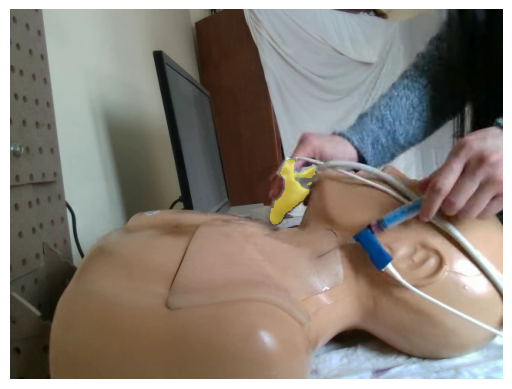

In [99]:
# visualize a prediction

VIDEO_IDX, FRAME_IDX = 15, 100


for j, video_folder in enumerate(video_folders): 

    if j != VIDEO_IDX: 
        continue

    output_path = f'{video_folder}_segmentations.npy'
    arr = np.load(
        output_path,
    )

    frames = sorted(list(glob(f"{video_folder}/*.jpg")))
    n_frames = len(frames)

    # get height and width
    image = cv2.imread(frames[0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    H, W, C = image.shape

    for i, frame in enumerate(tqdm(frames)): 
        if i != FRAME_IDX: continue
        image = cv2.imread(frame)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = arr[i]

        show(image, mask)
        break


In [63]:
arr = np.load(
    output_path,
)

 52%|█████▏    | 300/572 [00:00<00:00, 310.65it/s]


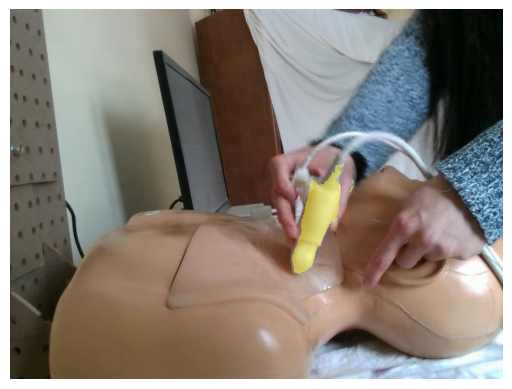

In [67]:
for i, frame in enumerate(tqdm(frames)): 

    image = cv2.imread(frame)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = arr[i] 

    if i == 300: 
        show(image, mask)
        break



In [56]:
arr[0].max()

1